# Training

In [4]:
from fastai.data.block import DataBlock
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

In [2]:
path = Path('/home/dant/data')

In [3]:
fns = get_image_files(path)
len(fns)

7915

In [4]:
failed = verify_images(fns)
len(failed)

0

In [5]:
failed.map(Path.unlink);


In [6]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
    # item_tfms=RandomResizedCrop(128, min_scale=0.8))


In [7]:
dls = db.dataloaders(path)

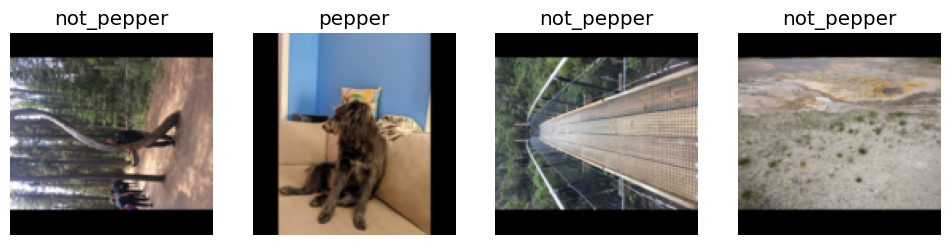

In [8]:
dls.valid.show_batch(max_n=4, nrows=1, unique=False)

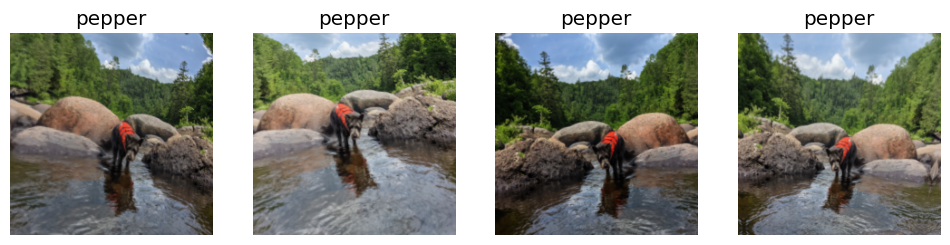

In [9]:
db = db.new(item_tfms=RandomResizedCrop(224, min_scale=0.8), batch_tfms=aug_transforms())
dls = db.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)


In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.606034,0.150191,0.039166,00:40


epoch,train_loss,valid_loss,error_rate,time
0,0.165451,0.120959,0.031586,00:40
1,0.100656,0.091504,0.036639,00:41
2,0.058601,0.046665,0.017688,00:41
3,0.038057,0.041607,0.015161,00:41


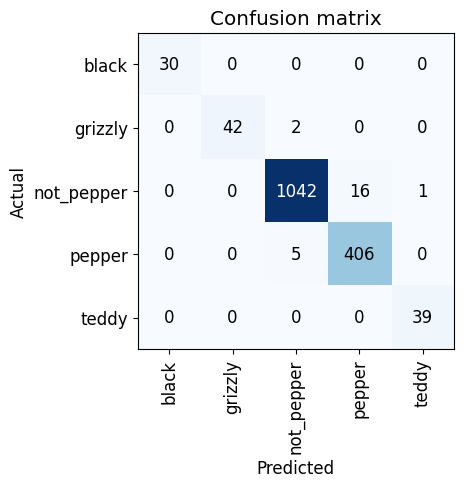

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

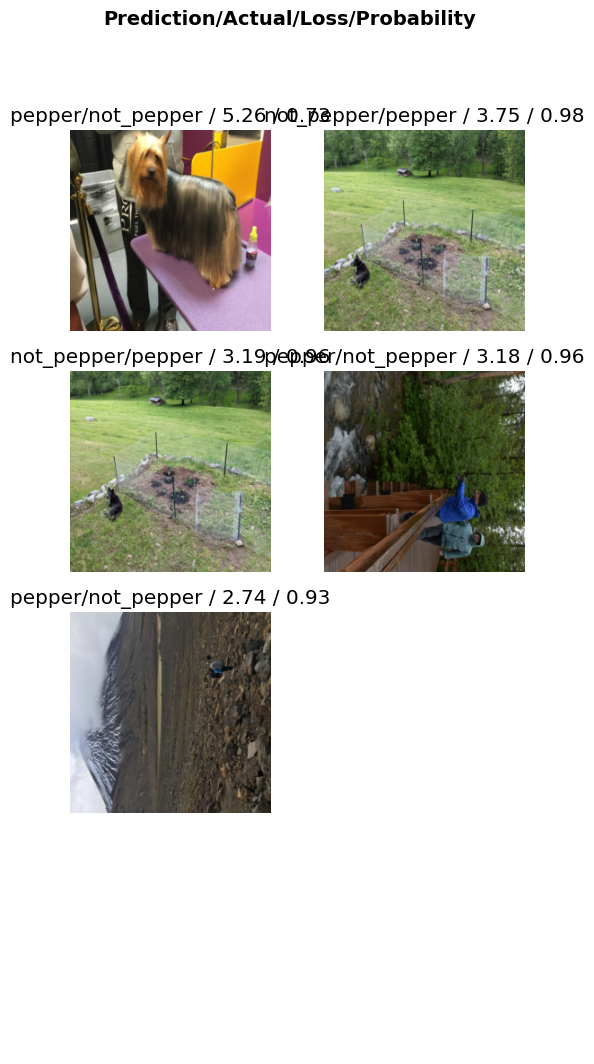

In [12]:
interp.plot_top_losses(5, nrows=4)


In [13]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [14]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [15]:
learn.export("model.pkl")

# After Training

In [17]:
#/export
from fastai.vision.all import *
import gradio as gr

learn = load_learner("model.pkl")

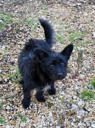

In [18]:
im = PILImage.create("images/dog1.jpg")
im.thumbnail((128, 128))
im

In [19]:
learn.predict(im)

('pepper',
 tensor(3),
 tensor([1.6593e-01, 4.4618e-03, 1.0909e-11, 8.2768e-01, 1.9271e-03]))

In [20]:
#/export

def classify_image(img):
    pred, idx, prob = learn.predict(img)
    return dict(zip(learn.dls.vocab, map(float, prob)))


In [21]:
classify_image(im)

{'black': 0.1659274399280548,
 'grizzly': 0.004461800213903189,
 'not_pepper': 1.0908913529450448e-11,
 'pepper': 0.827683687210083,
 'teddy': 0.0019271024502813816}

In [22]:
#/export
image = gr.Image(height=224, width=224)
label = gr.Label()

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label)
intf.launch(inline=False)

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
